In [83]:
source('../NMEG_utils/r_functions/load_nmeg.r')
library('xts')

In [84]:
site <- 'Mpj'
flux <- daily_to_xts(get_daily_file(site, 'aflx', make_new=FALSE))
soil <- daily_to_xts(get_daily_file(site, 'soilmet', make_new=FALSE))

In [89]:
get_decomp <- function(dframe, freq='Daily', sitename='Site ts decomp', per=52, plotdecomp=TRUE){
    ts1 <- dframe
    if (freq=='Daily'){
        attr(ts1, 'frequency') <- 365
    } else if (freq=='Weekly'){
        attr(ts1, 'frequency') <- 52
    } else if (freq=='Monthly'){
        attr(ts1, 'frequency') <- 12
    }
    # Timeseries decomp
    decomp_ts1 <- stl(as.ts(ts1), s.window="per", na.action=na.omit, robust=TRUE)
    if (plotdecomp==TRUE){ plot(decomp_ts1, main=site)}
    # Not sure why making a zoo first is needed
    decomp <- as.xts(zoo(decomp_ts1$time.series, index(dframe)))
    return(decomp)
}

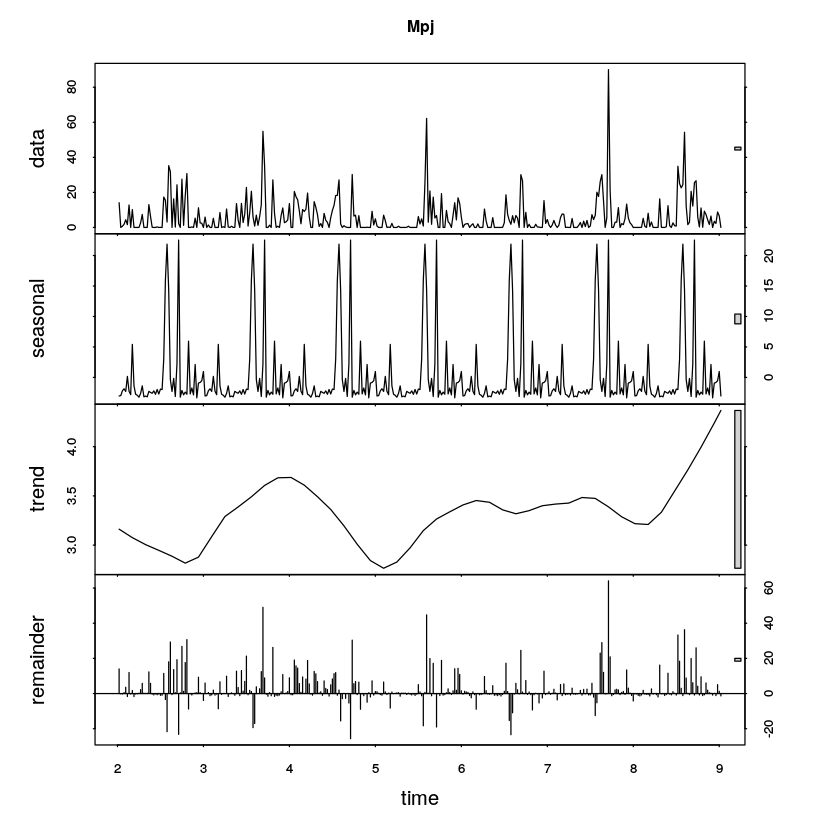

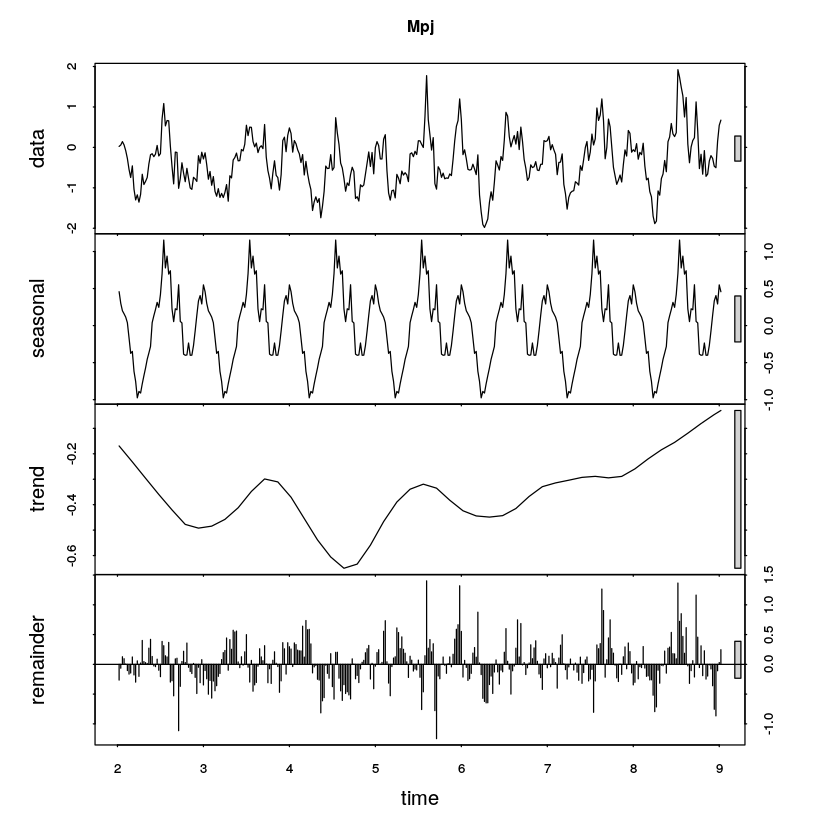

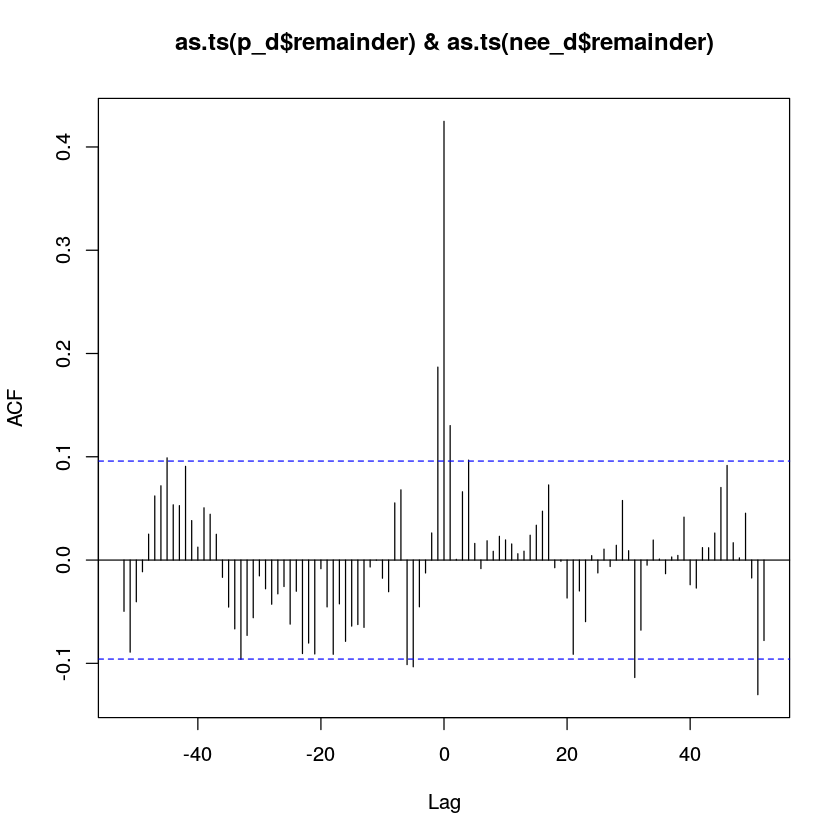

In [90]:
p <- apply.weekly(flux$P_F, sum)
swc <- apply.weekly(soil$deep_swc_interp, mean)
nee <- apply.weekly(flux$FC_F_g_int, mean)
gpp <- apply.weekly(flux$GPP_g_int, mean)
re <- apply.weekly(flux$RECO_g_int, mean)
p_d <- get_decomp(p, freq='Weekly', sitename=site)
nee_d <- get_decomp(nee, freq='Weekly', sitename=site)
ccf(as.ts(p_d$remainder), as.ts(nee_d$remainder), lag.max=52, na.action=na.omit)

[1] 53

[1] 53

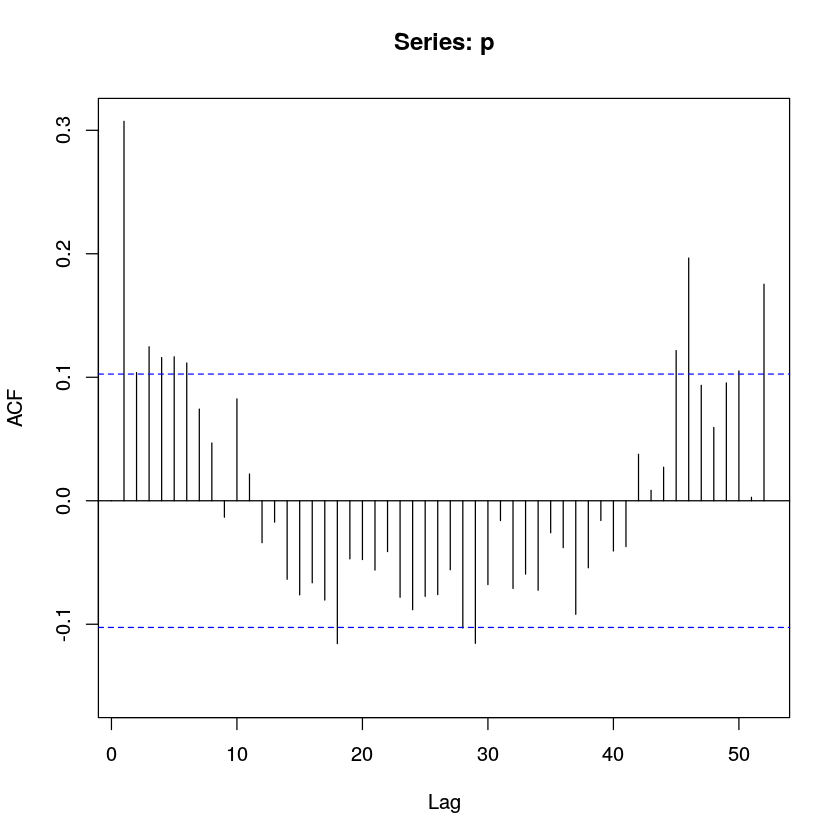


Call:
arima(x = p, order = c(1, 0, 0), xreg = time(p))

Coefficients:
         ar1  intercept  time(p)
      0.3066     0.6712    3e-04
s.e.  0.0498    14.7876    1e-03

sigma^2 estimated as 91.19:  log likelihood = -1341.58,  aic = 2691.16

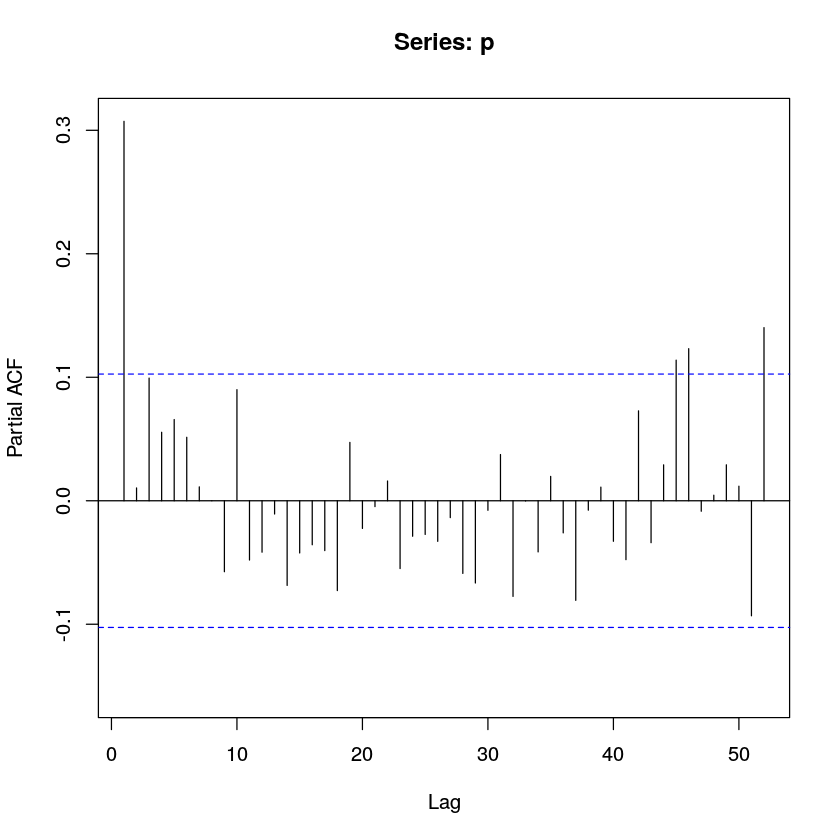

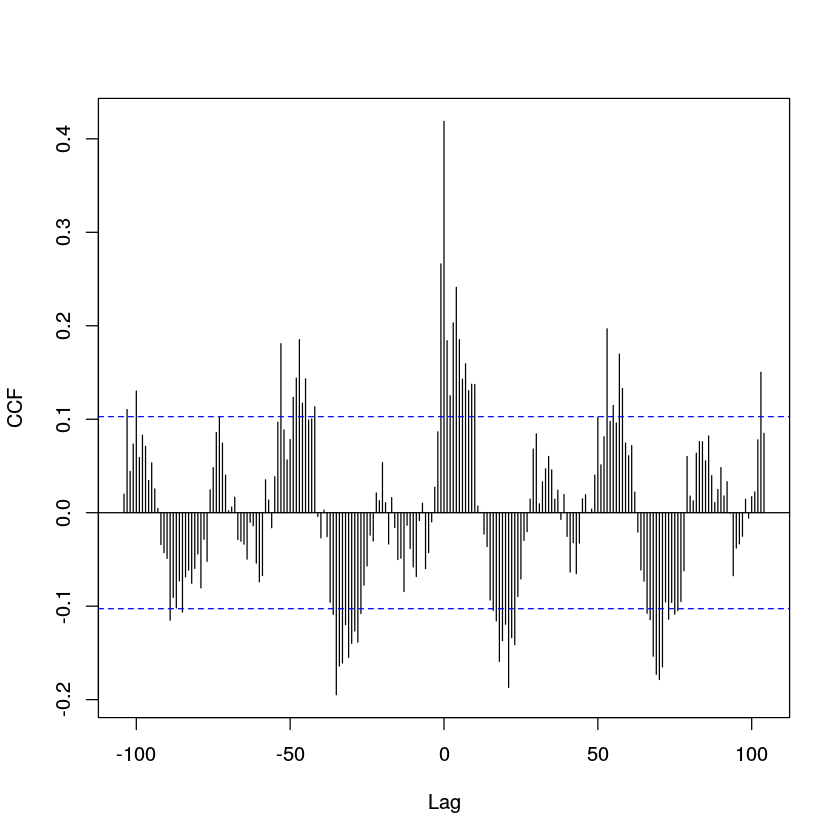

In [91]:
library(forecast)
#Check for missing data and crop timeseries
sum(is.na(p))
p <- p[54:nrow(p)]
# Could use other carbon fluxes here
sum(is.na(nee))
fc <- nee[54:nrow(nee)]
Acf(p, lag.max=52)
Pacf(p, lag.max=52)
(fit = arima(p, xreg=time(p), order=c(1, 0, 0)))
ar1 = as.numeric(fit$coef[1]) # = 0.8272
p.pw = resid(fit)
fc.d = resid(lm(fc~time(fc), na.action=NULL))
fc.fil = filter(fc.d, filter=c(1, -ar1), method="conv", sides=1)
ccf(p.pw, fc.fil, lag.max=104, main="", ylab="CCF", na.action=na.omit)


Call:
lm(formula = fc.d ~ 0 + fc.d1 + p.d1 + p.d40, data = nee)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.03329 -0.22918 -0.02801  0.20514  1.64131 

Coefficients:
        Estimate Std. Error t value Pr(>|t|)    
fc.d1  0.8362981  0.0360336  23.209   <2e-16 ***
p.d1  -0.0009395  0.0022719  -0.414    0.679    
p.d40 -0.0001469  0.0020513  -0.072    0.943    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3602 on 322 degrees of freedom
Multiple R-squared:  0.684,	Adjusted R-squared:  0.6811 
F-statistic: 232.3 on 3 and 322 DF,  p-value: < 2.2e-16


ACF,PACF
0.53,0.53
-0.29,-0.79
-0.67,0.08
-0.39,0.01
0.16,0.00
0.45,-0.01
0.29,0.01
-0.09,0.01
-0.28,0.04
-0.18,0.01



Call:
arima(x = eta.hat, order = c(3, 0, 0))

Coefficients:
         ar1      ar2     ar3  intercept
      1.0134  -0.8648  0.0756    -0.0019
s.e.  0.0554   0.0624  0.0553     0.0255

sigma^2 estimated as 0.1267:  log likelihood = -126.58,  aic = 263.15

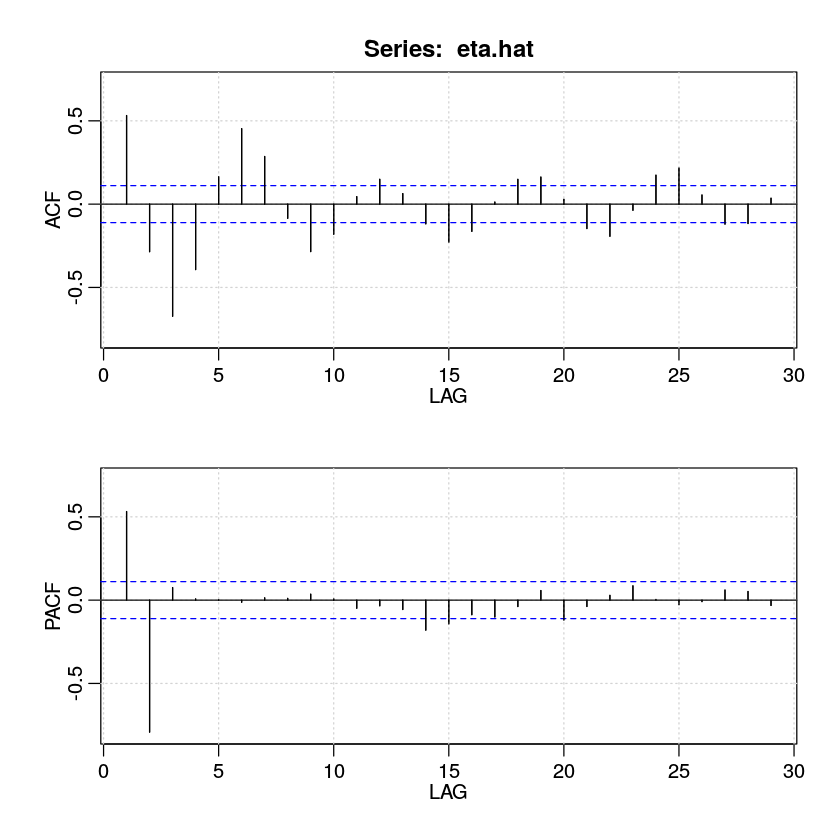

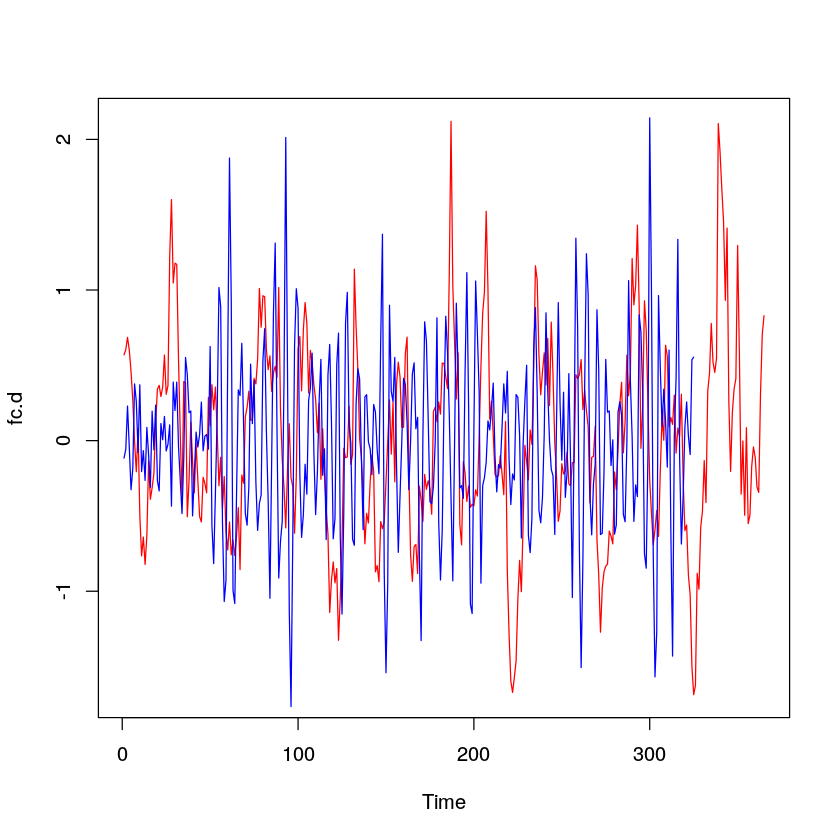

In [71]:
library(astsa)
fc.d = resid(lm(fc~time(fc), na.action=NULL))
p.d = resid(lm(p~time(p), na.action=NULL))
fc.d <- as.ts(fc.d)
p <- as.ts(p)
# Use p or p.d in lags?
nee = ts.intersect(fc.d, fc.d1=lag(fc.d,-1), p.d1=lag(p.d,-1), p.d40=lag(p.d,-40), dframe=TRUE)
summary(nee.fit <- lm(fc.d~0+fc.d1+p.d1+p.d40, data=nee))

om1 = as.numeric(nee.fit$coef[1])
eta.hat = filter(resid(nee.fit), filter=c(1,-om1), method="recur", sides=1)
acf2(eta.hat)
(eta.fit <- arima(eta.hat, order=c(3,0,0)))

plot(fc.d,col="red")
lines(fitted(eta.fit),col="blue")

[1] 84

[1] 53

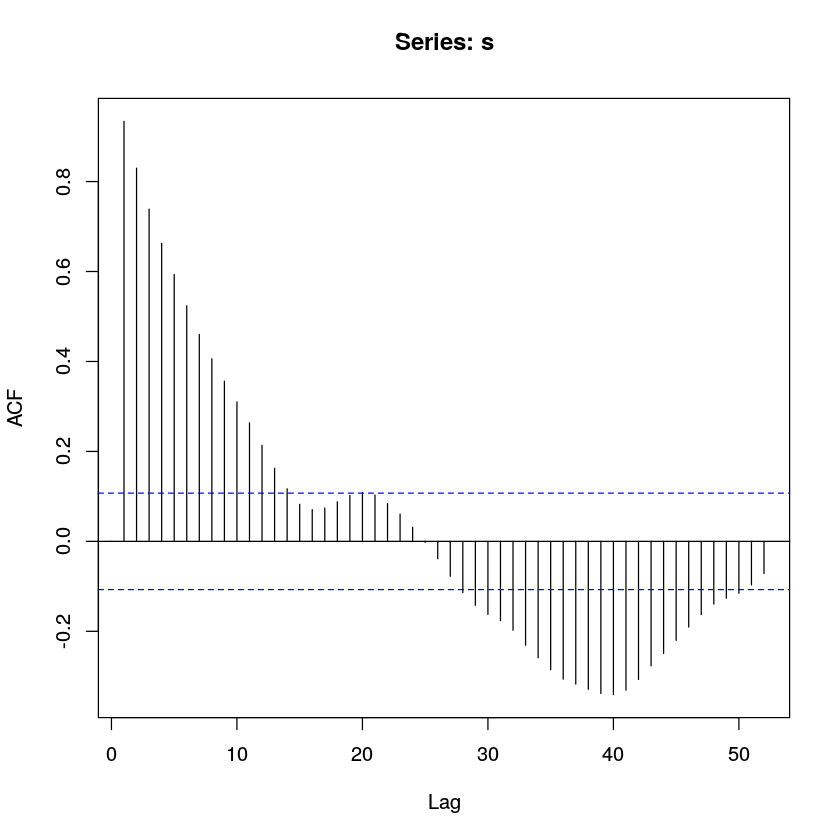


Call:
arima(x = s, order = c(2, 0, 0), xreg = time(s))

Coefficients:
         ar1      ar2  intercept  time(s)
      1.3005  -0.3905     3.0318   -1e-04
s.e.  0.0514   0.0513     1.5867    1e-04

sigma^2 estimated as 0.01461:  log likelihood = 230.64,  aic = -451.27

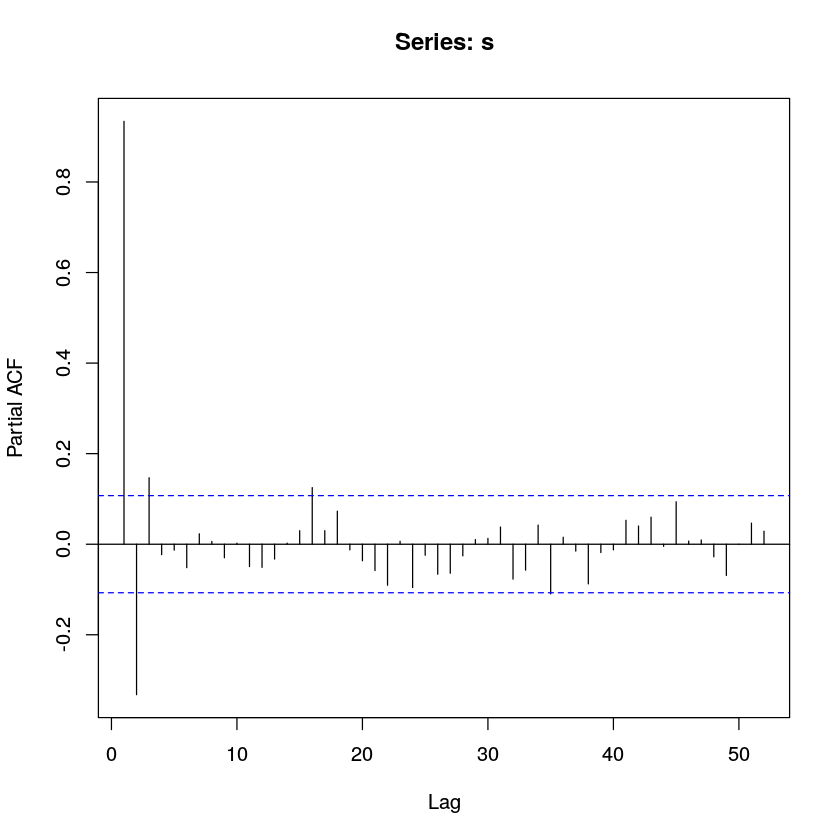

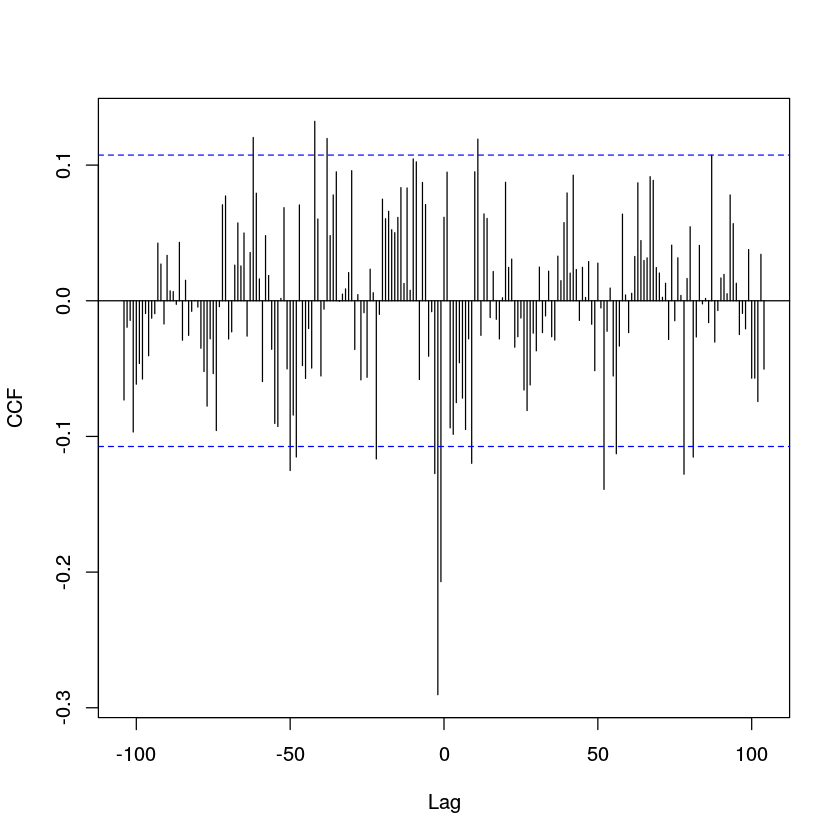

In [72]:
s <- apply.weekly(mpj_s$mid_swc_interp, sum)
sum(is.na(s))
s <- s[85:nrow(s)]
fc <- apply.weekly(mpj$FC_F_g_int, mean)
sum(is.na(fc))
fc <- fc[85:nrow(fc)]
Acf(s, lag.max=52)
Pacf(s, lag.max=52)
(fit = arima(s, xreg=time(s), order=c(2, 0, 0)))
ar1 = as.numeric(fit$coef[1]) # = 0.8272
s.pw = resid(fit)
fc.d = resid(lm(fc~time(fc), na.action=NULL))
fc.fil = filter(fc.d, filter=c(1, -ar1), method="conv", sides=1)
ccf(s.pw, fc.fil, lag.max=104, main="", ylab="CCF", na.action=na.omit)


Call:
lm(formula = fc.d ~ 0 + fc.d1 + s.d3, data = nee)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.99231 -0.20394  0.00516  0.24025  1.66382 

Coefficients:
      Estimate Std. Error t value Pr(>|t|)    
fc.d1  0.81713    0.03385  24.140   <2e-16 ***
s.d3  -0.02887    0.02271  -1.271    0.205    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3705 on 282 degrees of freedom
Multiple R-squared:  0.6812,	Adjusted R-squared:  0.6789 
F-statistic: 301.2 on 2 and 282 DF,  p-value: < 2.2e-16


      fc.d1        s.d3 
 0.81712777 -0.02887328 


ACF,PACF
0.54,0.54
-0.26,-0.78
-0.64,0.10
-0.39,-0.01
0.13,-0.01
0.40,-0.01
0.26,0.01
-0.05,0.03
-0.22,0.02
-0.15,0.01



Call:
arima(x = eta.hat, order = c(3, 0, 0))

Coefficients:
         ar1      ar2     ar3  intercept
      1.0283  -0.8663  0.0933     0.0306
s.e.  0.0591   0.0673  0.0591     0.0292

sigma^2 estimated as 0.1338:  log likelihood = -118.44,  aic = 246.88

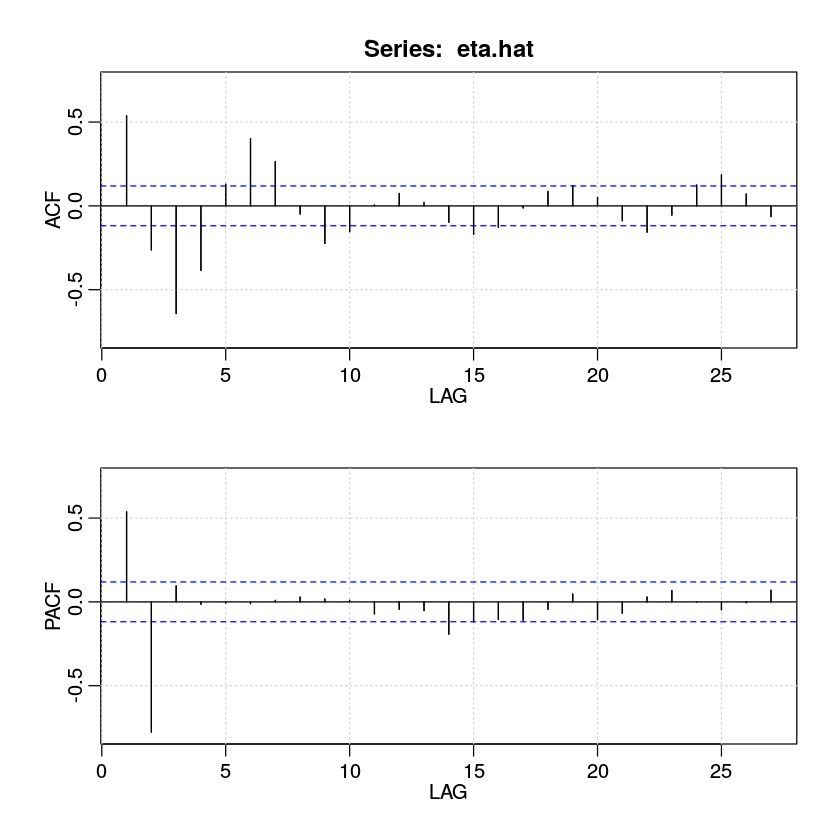

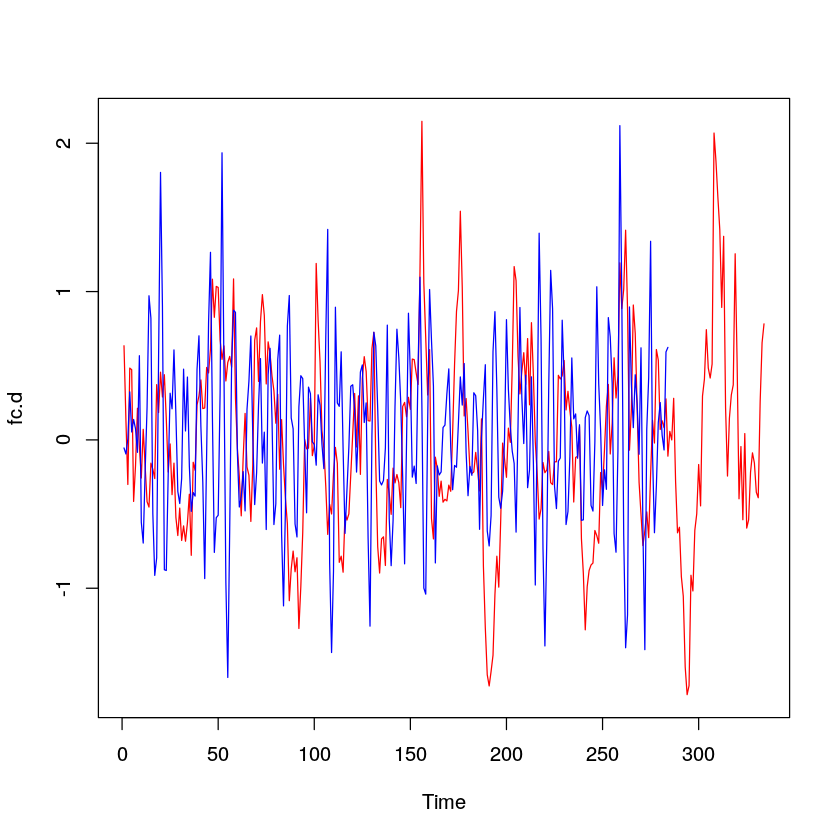

In [82]:
# Detrend fc and swc - should we also remove seasonal components?
fc.d = resid(lm(fc~time(fc), na.action=NULL))
s.d = resid(lm(s~time(s), na.action=NULL))
# Make into time series
fc.d <- as.ts(fc.d)
s <- as.ts(s)
# Make multivariate timeseries with detrended fc, lagged fc, and lagged swc
nee = ts.intersect(fc.d, fc.d1=lag(fc.d,-1), s.d3=lag(s,-3), s.d50=lag(s,-50),dframe=TRUE)
# Make linear model
summary(nee.fit <- lm(fc.d~0+fc.d1+s.d3, data=nee))
# Get coefficient
print(nee.fit$coef)
om1 = as.numeric(nee.fit$coef[1])
eta.hat = filter(resid(nee.fit), filter=c(1,-om1), method="recur", sides=1)
acf2(eta.hat)
(eta.fit <- arima(eta.hat, order=c(3,0,0)))

plot(fc.d,col="red")
#lines(fitted(lm(fc~time(fc), na.action=NULL)), col='black')
lines(fitted(eta.fit),col="blue")